<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/HienVersion_FinBigData_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')
#nb_path = '/content/notebooks2'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
#sys.path.insert(0,nb_path)

#!pip install --target=$nb_path arrow

Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

 AnitaVersion_FinBigData_1.ipynb
 arrow
 arrow-0.17.0.dist-info
 AUS.csv
 AUT.csv
 BEL.csv
 BRA.csv
 CAN.csv
 CHE.csv
 CHN.csv
 classification_3.ipynb
'classification_4 (1).ipynb'
 classification_4.ipynb
 classification.ipynb
 closed_form_solution.ipynb
'complete_mc (1).ipynb'
'complete_mc (2).ipynb'
 complete_mc.ipynb
'Copia di mc.ipynb'
 CZE.csv
 dateutil
 DEU.csv
 DNK.csv
 ESP.csv
 FIN.csv
 FRA.csv
 GBR.csv
 generate_dataset_dataset4.ipynb
 generate_dataset_fixedK_movingS0.ipynb
 generate_dataset.ipynb
 GHA.csv
'granger_causality_covid (1).ipynb'
 granger_causality_covid.ipynb
 granger_causality_japan.ipynb
'granger_causality_many_cuntries (1).ipynb'
 granger_causality_many_cuntries.ipynb
 GRC.csv
'Heston_Project (1).ipynb'
'Heston_Project (2).ipynb'
 Heston_Project.ipynb
 HienCovidDataRetrieval.ipynb
 HRV.csv
 IRL.csv
 ITA.csv
 JPN.csv
 NLD.csv
 notebooks2
 NZL.csv
 POL.csv
 PRT.csv
 __pycache__
 python_dateutil-2.8.1.dist-info
 RUS.csv
 six-1.15.0.dist-info
 six.py
 SWE.csv
 THA.c

In [4]:
root = "/content/drive/My Drive/Colab Notebooks" 

In [5]:
!pip install arrow

     |████████████████████████████████| 51kB 3.7MB/s 


## Data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# other libraries here
import requests
import arrow

In [8]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [9]:
# TODO: we need to decide on a fixed END date - December 1st!

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-01"
end_date = "2020-12-01" # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
    query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
    res = requests.get(query).json()
    df = pd.DataFrame(res["result"])
    df.index = pd.DatetimeIndex(df["date"], tz="utc")
    df.drop(columns=["date"])
    df["date"] = pd.to_datetime(df["date"])
    df["ts_in_secs"] = df["date"].astype(int)
    df["new_confirmed"] = df["confirmed"].diff().fillna(0)
    df.to_csv(f"{root}/{country}.csv")
    dfs[country] = df

## Analysis

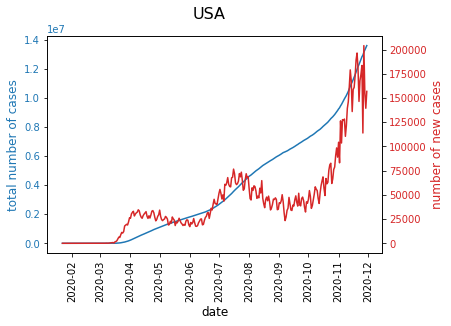

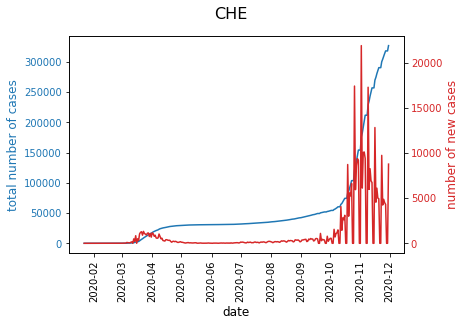

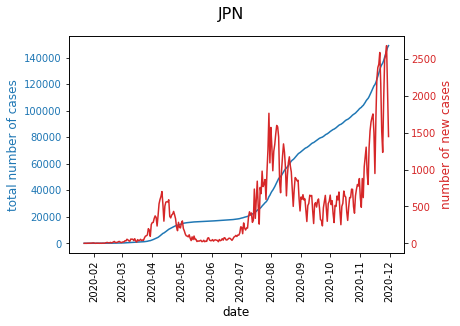

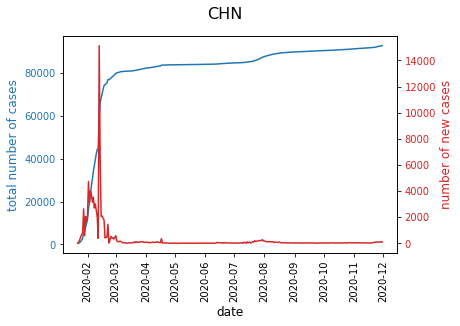

In [10]:
# first overview
for country,df in dfs.items():  
    fig,ax1 = plt.subplots()
    ax1.plot(df.index, df["confirmed"])
    ax1.set_xlabel("date", size=12)
    ax1.tick_params(labelrotation=90, axis="x")
    color = "tab:blue"
    ax1.set_ylabel("total number of cases", color=color, size=12)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()
    color="tab:red"
    ax2.plot(df.index, df["new_confirmed"], color=color)
    ax2.set_ylabel("number of new cases", color=color, size=12)
    ax2.tick_params(axis="y", labelcolor=color)
    fig.suptitle(country, size=16)

    #fig.tight_layout()  
    plt.show()

### Distribution of new cases


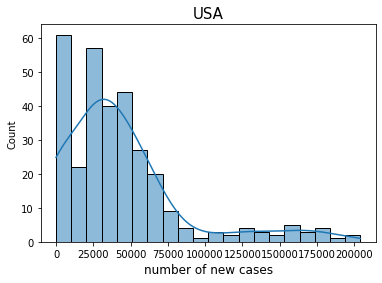

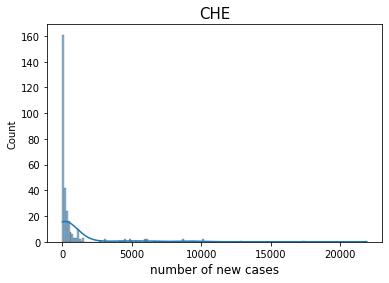

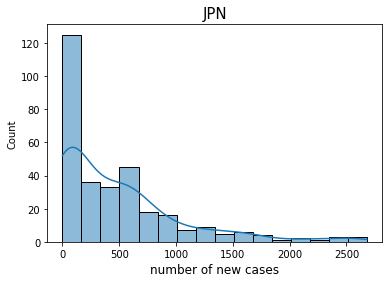

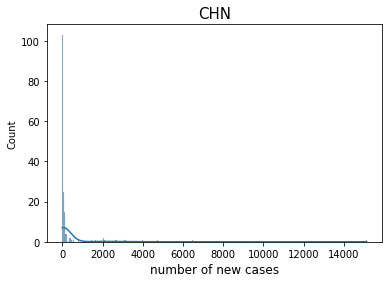

In [11]:
for country,df in dfs.items():
    plt.figure()
    sns.histplot(df["new_confirmed"], kde=True)
    plt.xlabel("number of new cases", size=12)
    plt.title(country, size=15)
    plt.show()

### Per month

The boxplots below show (potentially) the month(s) where these countries experienced a jump or a big change in the number of new cases. For example, Switzerland experienced some very fast increase in cases in October and November which caused the boxplots to be so wide and with even outliers.

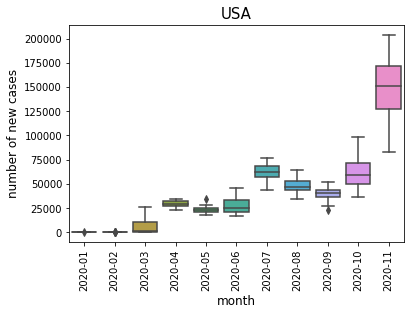

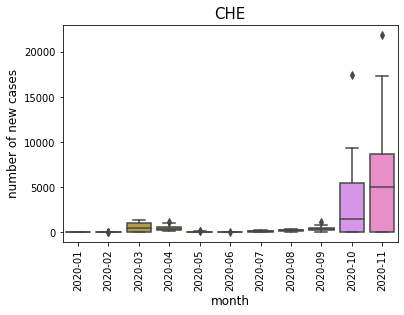

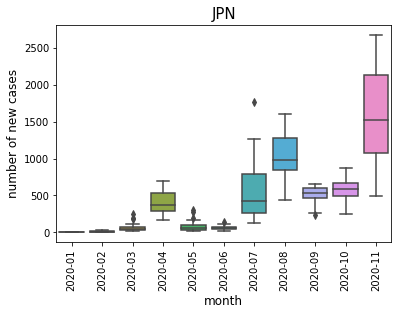

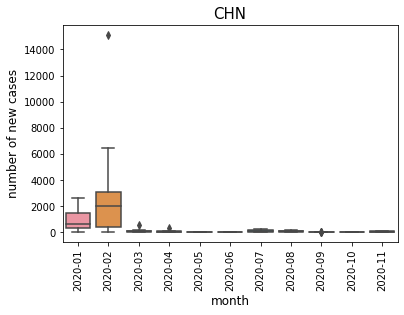

In [12]:
for country,df in dfs.items():
    df["month"] = df["date"].dt.to_period("M")
    plt.figure()
    sns.boxplot(data=df, x="month", y="new_confirmed")
    plt.xticks(rotation=90)
    plt.xlabel("month", size=12)
    plt.ylabel("number of new cases", size=12)
    plt.title(country, size=15)
    plt.show()

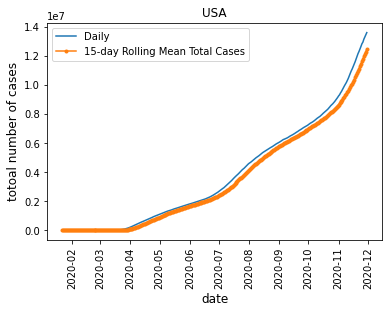

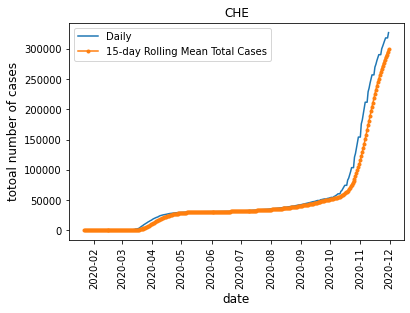

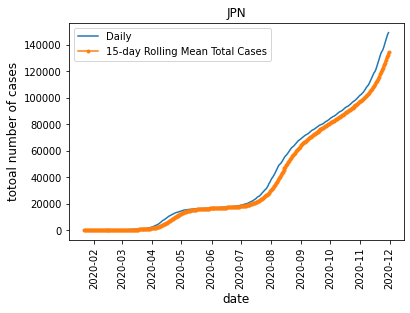

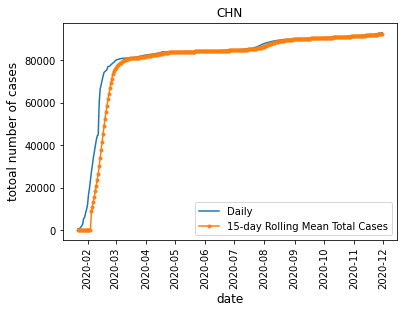

In [15]:
# rolling for cumulative => could also be solution for the problem of late
# registration of data or non-granularity

rolling_period = 15 # days
for country,df in dfs.items():
    df_rolling = df["confirmed"].rolling(rolling_period).mean().fillna(0)
    plt.figure()
    plt.plot(df.date, df["confirmed"], label="Daily")
    plt.plot(df.date, df_rolling, marker=".", label=f"{rolling_period}-day Rolling Mean Total Cases")
    plt.xticks(rotation=90)
    plt.xlabel("date", size=12)
    plt.ylabel("totoal number of cases", size=12)
    plt.title(country)
    plt.legend()
    plt.show()

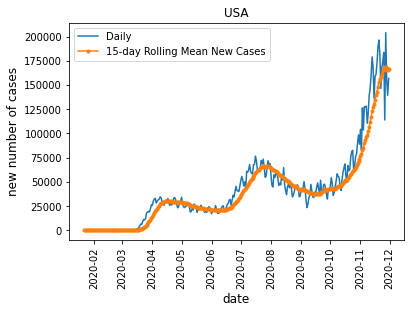

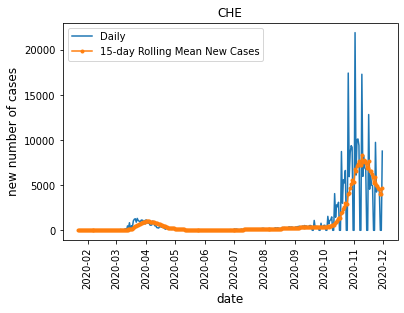

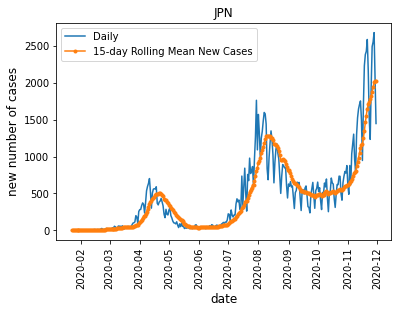

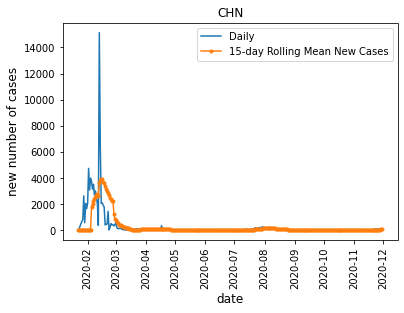

In [16]:
# rolling for cumulative => could also be solution for the problem of late
# registration of data or non-granularity

rolling_period = 15 # days
for country,df in dfs.items():
    df_rolling = df["new_confirmed"].rolling(rolling_period).mean().fillna(0)
    plt.figure()
    plt.plot(df.date, df["new_confirmed"], label="Daily")
    plt.plot(df.date, df_rolling, marker=".", label=f"{rolling_period}-day Rolling Mean New Cases")
    plt.xticks(rotation=90)
    plt.xlabel("date", size=12)
    plt.ylabel("new number of cases", size=12)
    plt.title(country)
    plt.legend()
    plt.show()

A rolling window of 10 days makes sense because this period corresponds to the incubation period. So, we are able to capture triggering events. 

### Per period

In [ ]:
mid_period = ("2020-06-12", "2020-10-12")  # arbitrarily chosen, subject to change             
first_period = (start_date, mid_period[0]) # beginning of pandemic
last_period = (mid_period[1], end_date) # most recent 

periods = [first_period, mid_period, last_period]

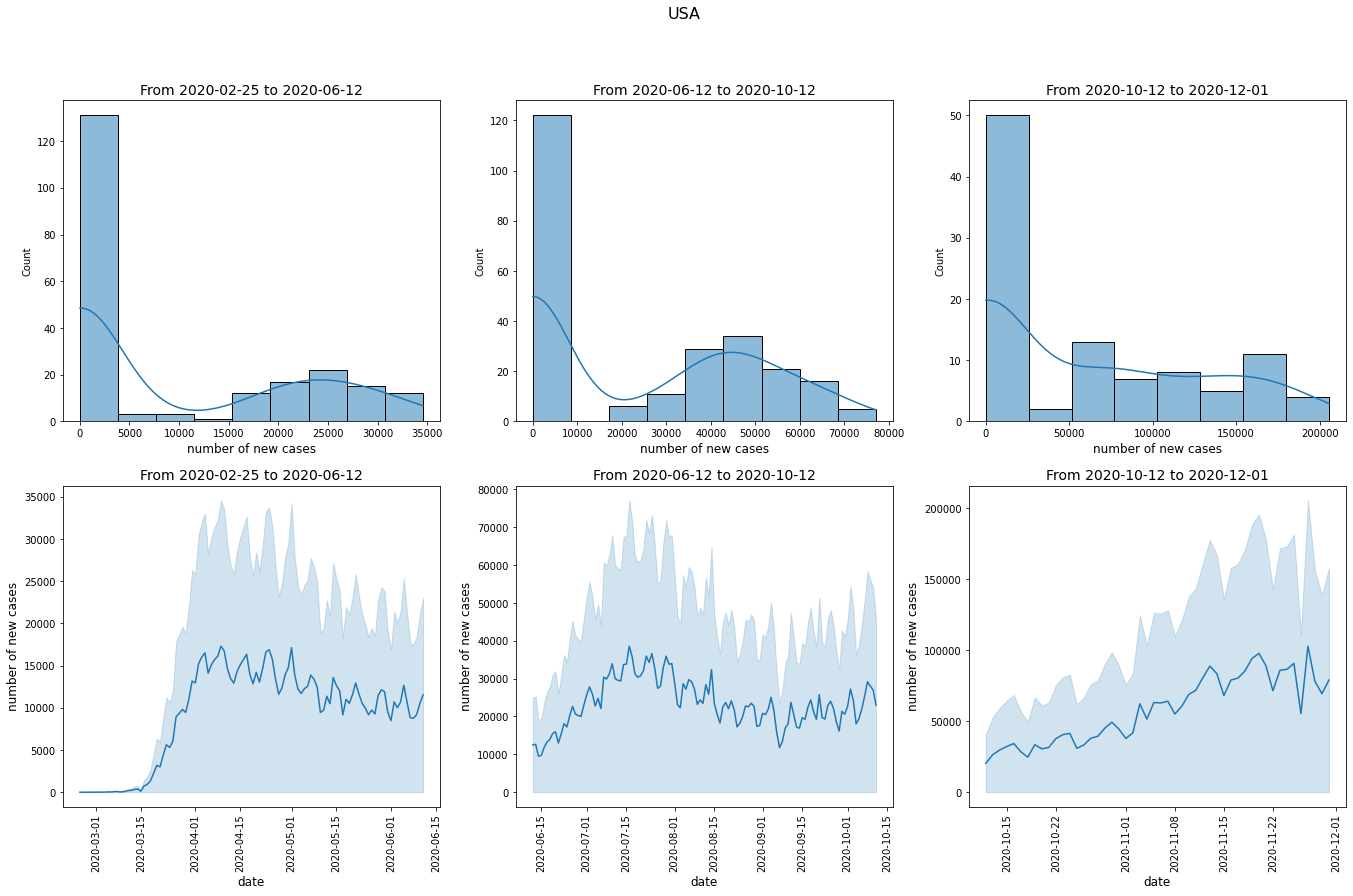

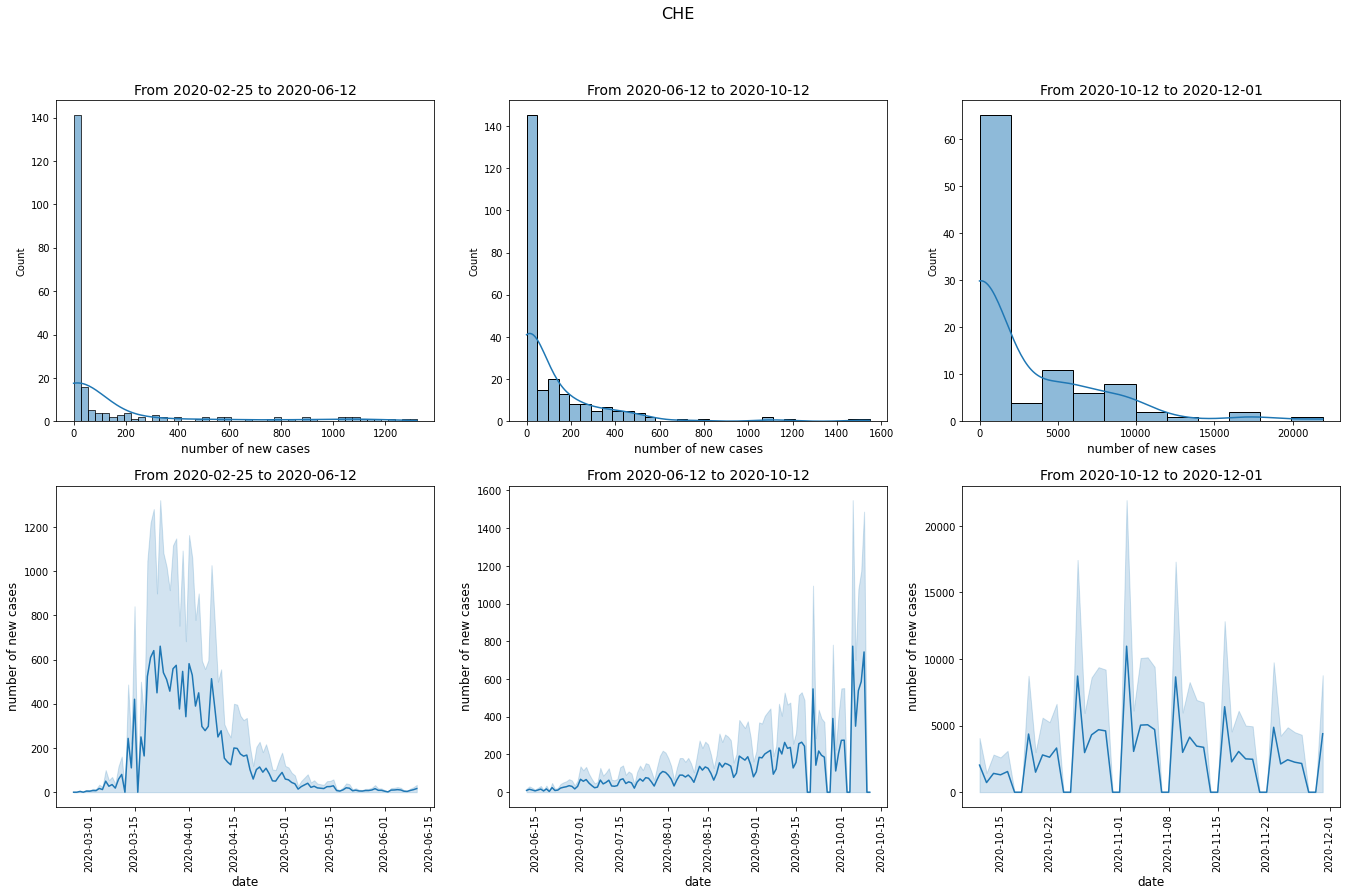

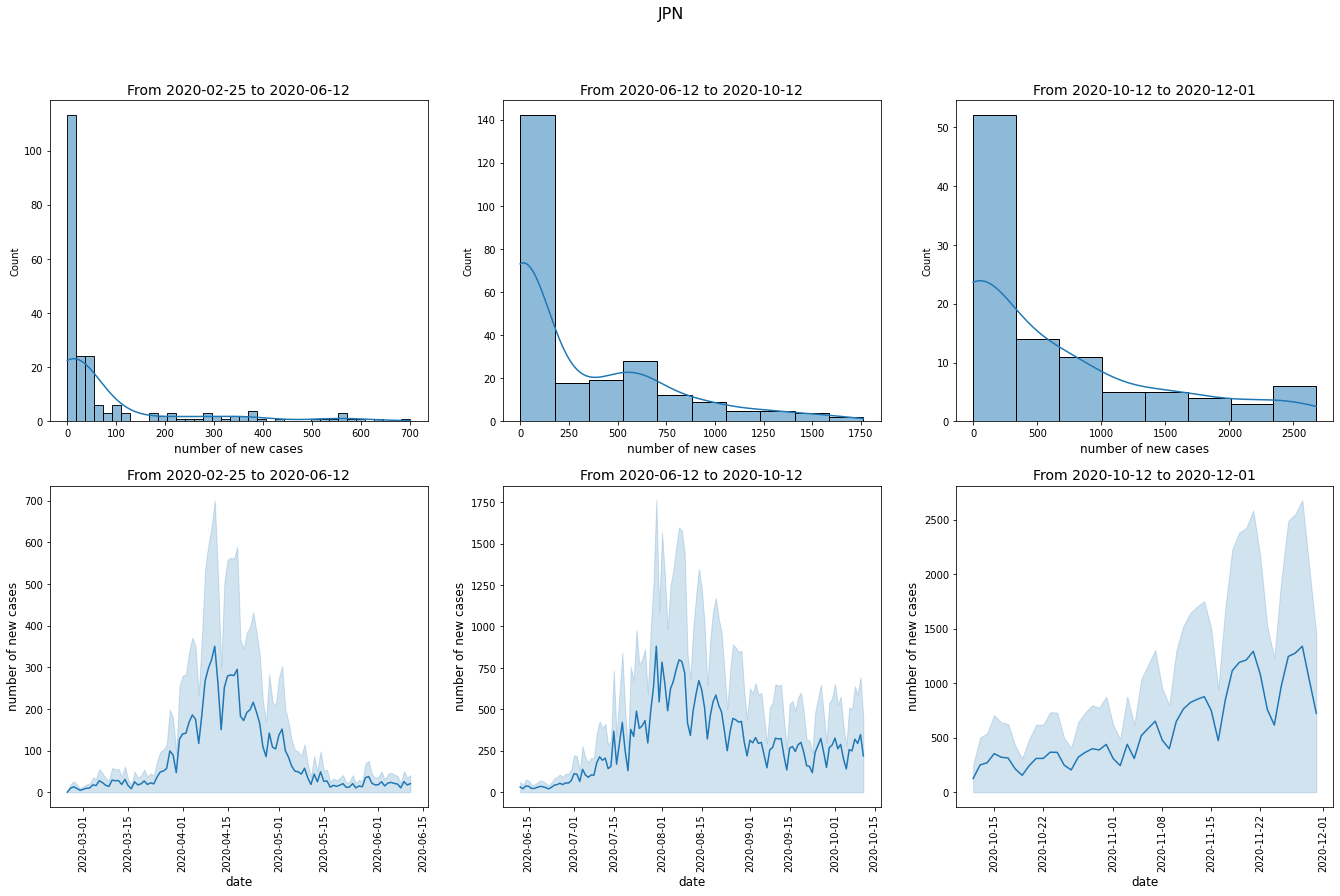

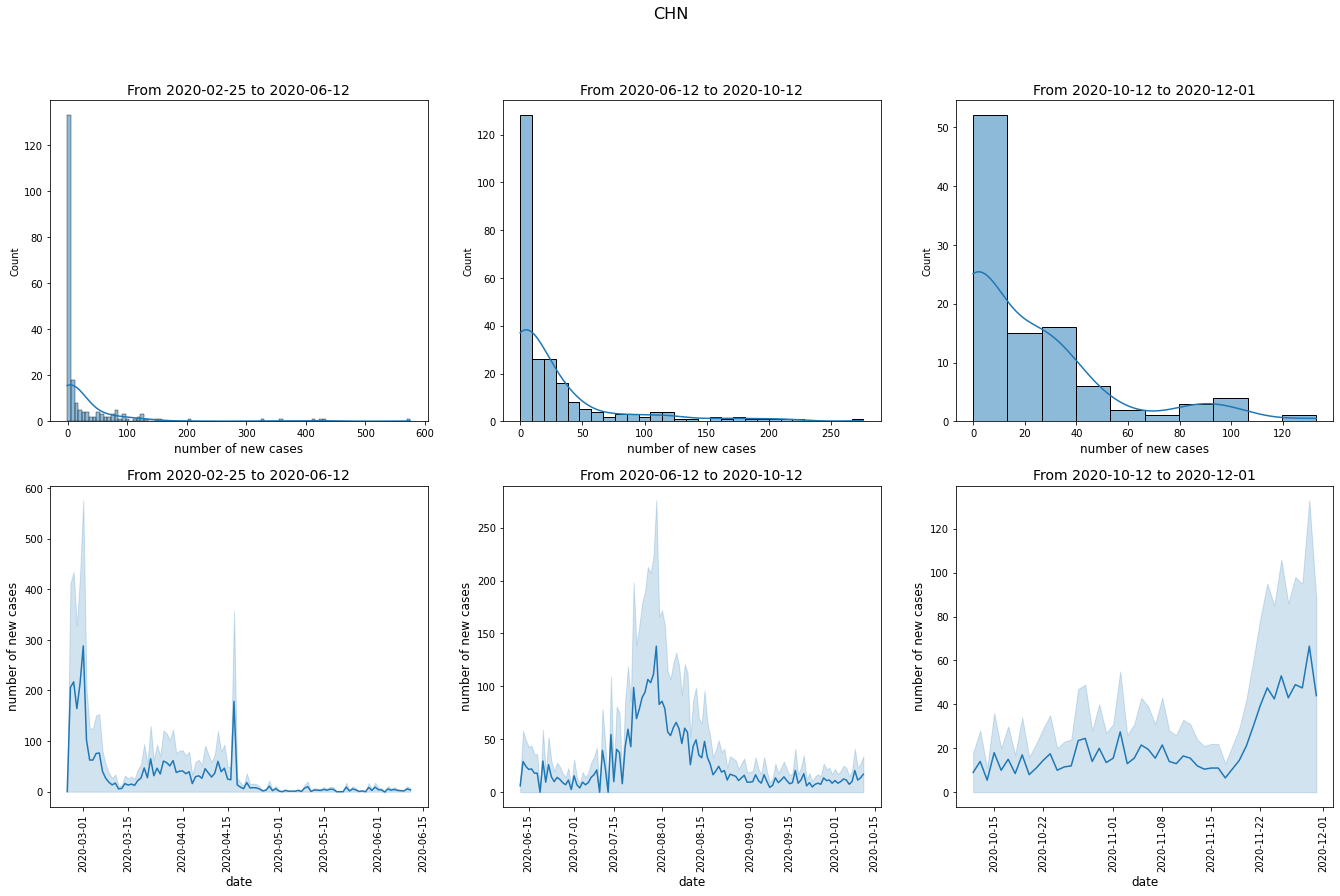

In [ ]:
# test = dfs["CHE"]
# test[test.index > mid_period[0]]

for country,df in dfs.items():
  fig, axes = plt.subplots(2,3,figsize=(23,13))
  axes = axes.flatten()

# distribution
  for i in range(len(periods)):
      df_period = df[(df.index >= periods[i][0]) & (df.index < periods[i][1])]
      sns.histplot(df_period["new_confirmed"], kde=True, ax=axes[i])
      axes[i].set_xlabel("number of new cases", size=12)
      axes[i].set_title(f"From {periods[i][0]} to {periods[i][1]}", size=14) 

      sns.lineplot(data=df_period, x="date", y="new_confirmed", ax=axes[i+3])
      axes[i+3].tick_params(axis="x", rotation=90)
      axes[i+3].set_xlabel("date", size=12)
      axes[i+3].set_ylabel("number of new cases", size=12) 
      axes[i+3].set_title(f"From {periods[i][0]} to {periods[i][1]}", size=14) 
  fig.suptitle(country, size=16)
  plt.show()

#### Comparing time series

In [ ]:
for country,df in dfs.items():
  # ...
  ...

In [ ]:
# China vs Japan
# ...


# US vs CH
# ...